# This script used to show graph of jumps users between clusters

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as font_manager
import networkx as nx
import pydotplus
from networkx.drawing.nx_pydot import graphviz_layout
%matplotlib inline

Initializing

In [2]:
pinfo = 'pinfo.csv'
border_times = [7,14,28,56,200]
all_ids = set([int(x) for x in pd.read_csv(pinfo,sep = '|', low_memory = False)['id']])

This is loader of cluster data from files

In [3]:
clusters_dicts = [] # day, {dictionary[cluster_id] : set of id }
for days in border_times:
    fname = 'cluster_elements_%d.csv'%days
    df = pd.read_csv(fname,sep = '|', low_memory = False)
    elements = dict()
    for x in xrange(10):
        filt = df[df['cluster_index']==x]['id']
        if len(filt)==0: break
        elements[x] = set(filt)
    unacted = set(all_ids)
    for x in elements:
        unacted = unacted - elements[x]
    elements[-1] = unacted
    clusters_dicts.append((days,elements))

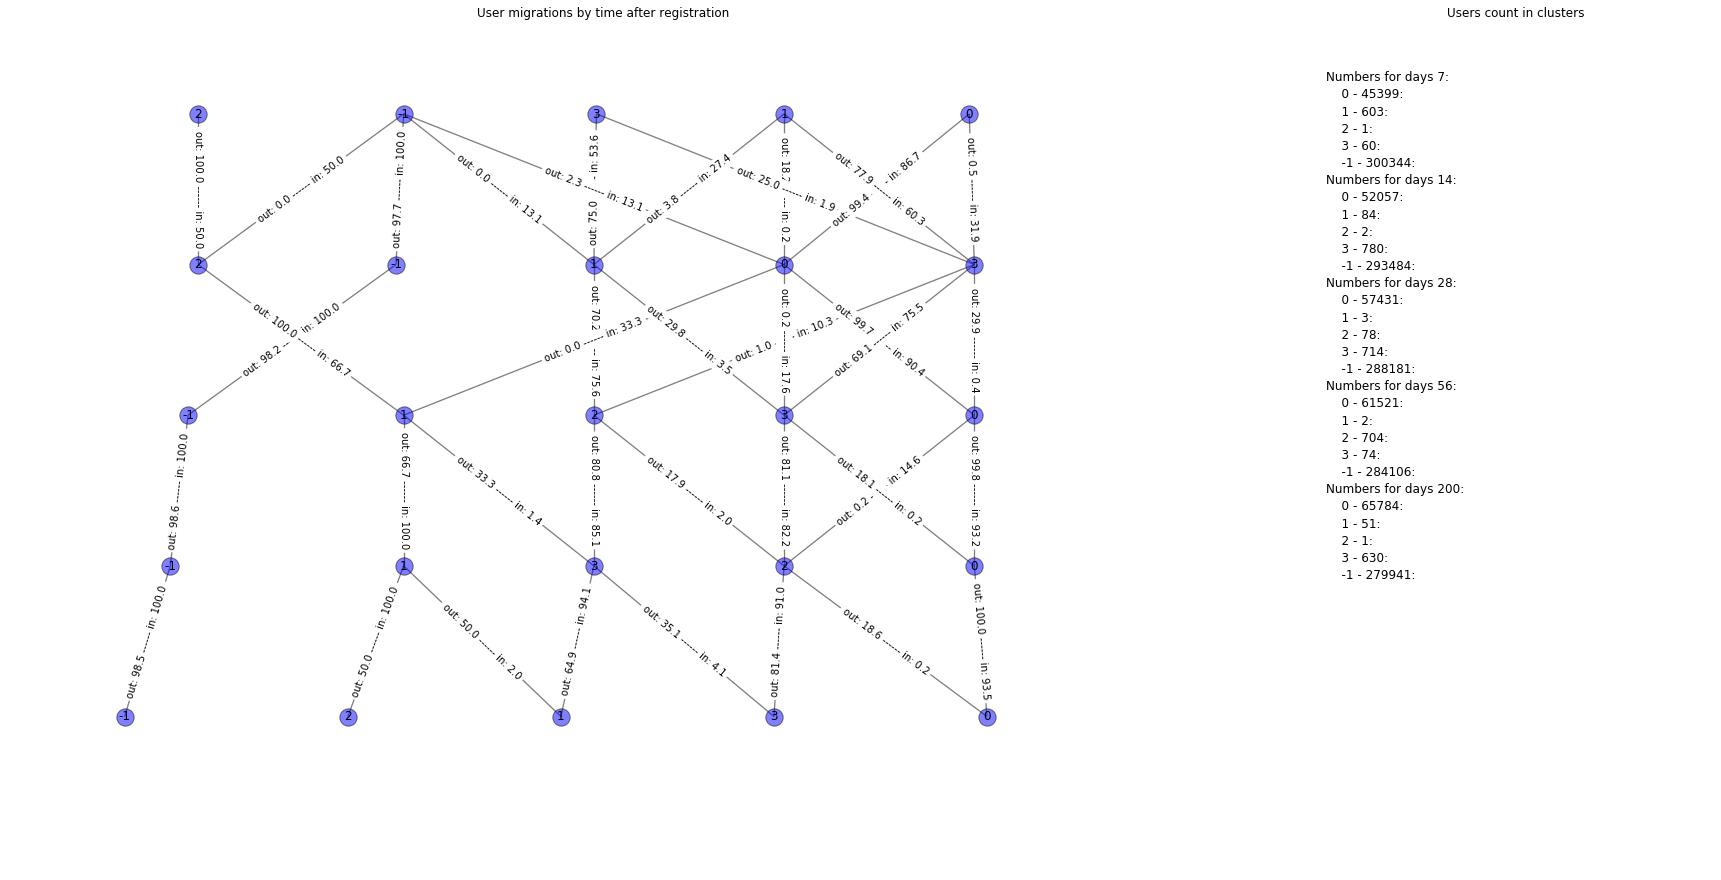

In [4]:
graph = nx.DiGraph()
# how many of input or output by the cluster must be to draw this edge
significance = 0.1
# adding nodes
lbs = dict()
for x in clusters_dicts:
    for cluster in x[1]:
        graph.add_node(str(x[0]) + '_' + str(cluster))
        lbs[str(x[0]) + '_' + str(cluster)] = str(cluster)
# adding edges
edge_lbs = dict()
for i in xrange(len(border_times)-1):
    prev = clusters_dicts[i][1]
    nxt = clusters_dicts[i+1][1]
    for c_p_id in prev:
        for c_n_id in nxt:
            inters = prev[c_p_id] & nxt[c_n_id]
            part_out = len(inters)*1./len(prev[c_p_id])
            part_in = len(inters)*1./len(nxt[c_n_id])
            if part_out>=significance or part_in>=significance:
                edge = str(clusters_dicts[i][0]) + '_' + str(c_p_id),str(clusters_dicts[i+1][0])+ '_' + str(c_n_id)
                graph.add_edge(edge[0], edge[1])
                # Здесь много тире, так как я делаю костыль, ибо надписи на рёбрах графа перекрываются
                # Для раскрытия художественного замысла сего костыля пишу комментарии на русском
                # Dashes were used for avoiding collision of labels 
                edge_lbs[edge] = "out: %.1f ------ in: %.1f"%  (100*part_out, 100*part_in) 
                #edge_lbs[edge] = "%d ------------"%  len(inters) 
pos = graphviz_layout(graph, prog='dot', args='')
fig = plt.figure(figsize=(30, 15))
# sizes of subplots
grid_spec = gridspec.GridSpec(1,2, width_ratios=[3, 1])
# nodes of the graph
ax = fig.add_subplot(grid_spec[0])
ax.axis('off')
ax.set_title('User migrations by time after registration')
# nx.draw(G, pos, node_size=400, alpha=0.5, node_color=clrs, labels = lb2, arrows=False, width = 2)
nx.draw_networkx_edges(graph, pos, node_size=400, alpha=0.5, arrows=False, width = 1.3)
nx.draw_networkx_nodes(graph, pos,node_color = 'b', alpha = 0.5)
nx.draw_networkx_labels(graph, pos, node_size=400,  width = .3, labels = lbs)
nx.draw_networkx_edge_labels(graph, pos, node_size=400,  width = .3, edge_labels = edge_lbs)
# some info in right
ax = fig.add_subplot(grid_spec[1])
ax.axis('off')
vertical_margin_multiplier = 1.3
font_size = 12
font_properties = font_manager.FontProperties(size = font_size)
fheight = font_properties.get_size_in_points()
tick = 0.4/((sum([len(x) for x in clusters_dicts])+len(clusters_dicts))*vertical_margin_multiplier)
tick = (1+vertical_margin_multiplier)*fheight if (1+vertical_margin_multiplier)*fheight < tick else tick
cntx = 0.95
ax.set_title('Users count in clusters')
for days in border_times:
    cntx -= tick
    ax.text(0, cntx,'Numbers for days %d:'%days, fontsize=font_size)
    for cluster_dict in [x[1] for x in clusters_dicts if x[0]==days]:
        for cluster_id in cluster_dict:
            cntx -= tick
            ax.text(0, cntx,'    %d - %d:'%(cluster_id, len(cluster_dict[cluster_id])), fontsize=font_size)
fig.savefig("out.png")

while True:
    print 'First'
    print 'Input index of period'
    i0 = input()
    print 'Input index of cluster'
    ci0 = input()
    print 'Second'
    print 'Input index of period'
    i1 = input()
    print 'Input index of cluster'
    ci1 = input()
    print 'Len %d'% len(clusters_dicts[i0][1][ci0] & clusters_dicts[i1][1][ci1])